# 6.6 Sourcing & Analyzing Time-Series Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

## Importing Data

In [30]:
# Defining a path
path = r'/Users/hectorvargas/Desktop/Career_Foundry/12-2022 Gun Violence Analysis'

In [31]:
df = pd.read_csv(os.path.join(path, '02 Data','Prepared Data', 'gun_violence_script2.csv'))

### Data wrangling

In [32]:
df.shape

(239677, 12)

In [33]:
df.head()

,Unnamed: 0,state,n_killed,Childs,Teens,Adults,Male,Female,date,year,month,day
0,0,Pennsylvania,0,0.0,0.0,5.0,3.0,1.0,2013-01-01,2013,January,1
1,1,California,1,0.0,0.0,4.0,1.0,0.0,2013-01-01,2013,January,1
2,2,Ohio,1,0.0,0.0,5.0,5.0,0.0,2013-01-01,2013,January,1
3,3,Colorado,4,0.0,0.0,4.0,3.0,1.0,2013-01-05,2013,January,5
4,4,North Carolina,2,0.0,1.0,3.0,2.0,2.0,2013-01-07,2013,January,7


In [34]:
df.isnull().values.any()

True

In [35]:
df = df.fillna(0)

In [36]:
df.isnull().values.any()

False

In [41]:
df.head()

,Unnamed: 0,state,n_killed,Childs,Teens,Adults,Male,Female,date,year,month,day
0,0,Pennsylvania,0,0.0,0.0,5.0,3.0,1.0,2013-01-01,2013,January,1
1,1,California,1,0.0,0.0,4.0,1.0,0.0,2013-01-01,2013,January,1
2,2,Ohio,1,0.0,0.0,5.0,5.0,0.0,2013-01-01,2013,January,1
3,3,Colorado,4,0.0,0.0,4.0,3.0,1.0,2013-01-01,2013,January,5
4,4,North Carolina,2,0.0,1.0,3.0,2.0,2.0,2013-01-01,2013,January,7


In [44]:
# Creating a new dataframe with sum of killed grouped by dates
data = df.groupby('date').agg({'n_killed': ['sum']})

In [49]:
# Checking headers

data.head(63)

,n_killed
,sum
date,
2013-01-01,23
2013-02-01,14
2013-03-01,25
2013-04-01,26
2013-05-01,20
...,...
2017-11-01,1304
2017-12-01,1288


In [50]:
# Checking data types

data.dtypes

n_killed  sum    int64
dtype: object

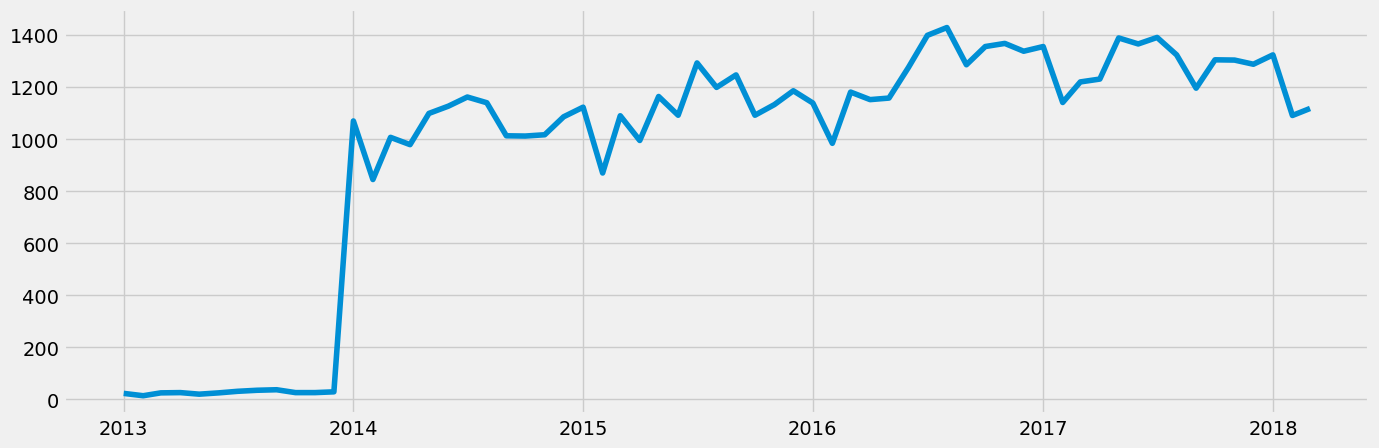

In [51]:
# Plotting the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

## 04. Decomposing Time-Series Data

In [52]:
# Decomposing time series using 

decomp = sm.tsa.seasonal_decompose(data, model='additive')

In [53]:
# Defining a fixed size for all special charts

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

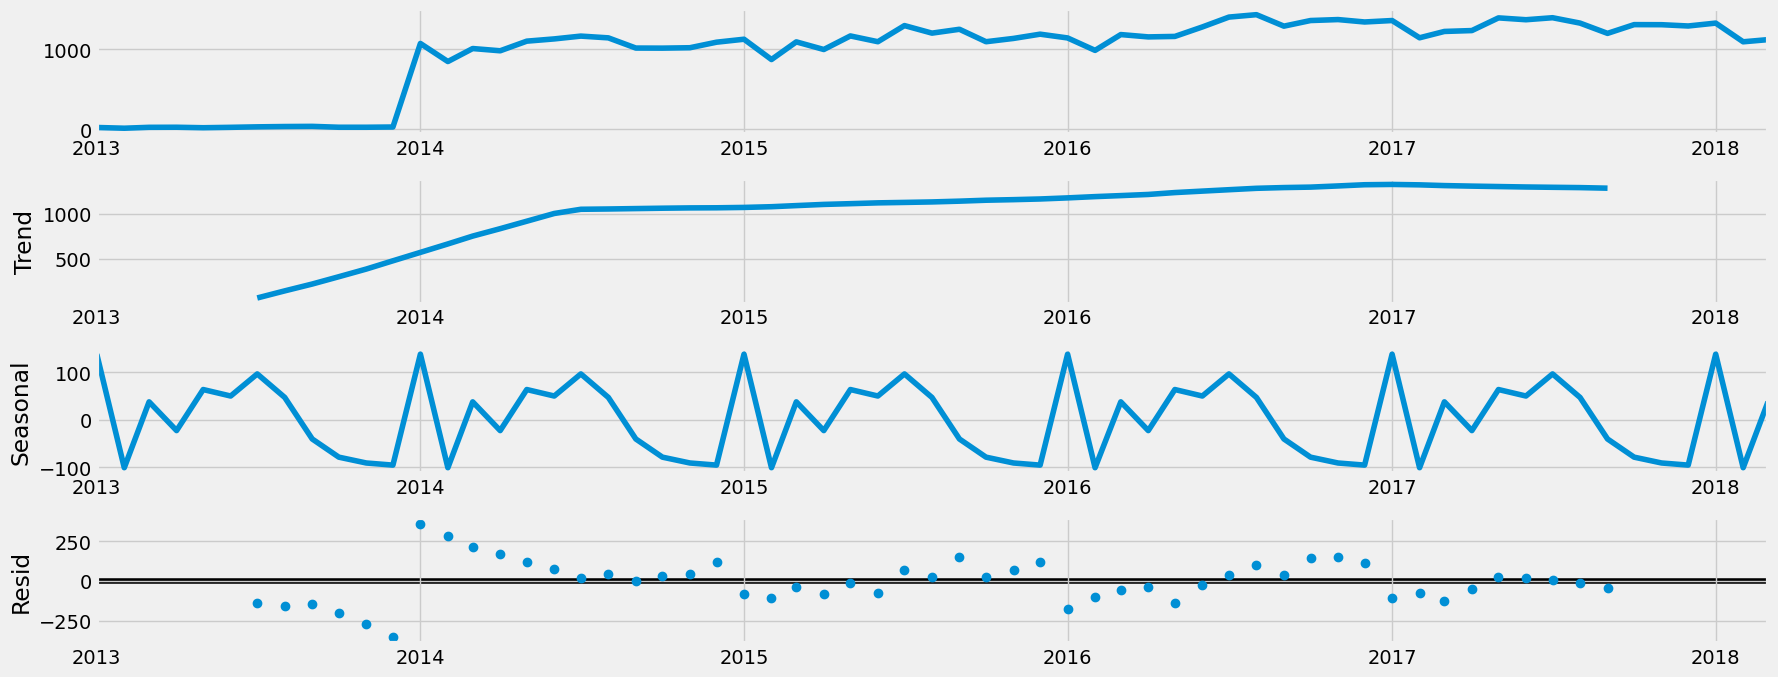

In [54]:
# Plotting decomposition of time-series data

decomp.plot()
plt.show()

#### The decomposition shows a stable upward trend in the number of kills in the US from 2014-2018. The first two charts appear different due to the data being unsmoothed. The plot shows seasonality due to a pattern repeating itself at the same time each year, with a spike at the beginning of each year and an upwards trend in the first months. The number of kills activities goes down from August and gradually declines. There is a massive peak in December, most likely due to the holiday season. 

## 05. Stationarity Test

### Dickey-Fuller Test

In [56]:
 # Import the adfuller() function

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['n_killed'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.577716e+00
p-value                        2.200454e-16
Number of Lags Used            1.100000e+01
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


#### Even Though the test statistic of -9.5777 is smaller than the critical value (5%) of -2.92014, meaning the null hypothesis can be rejected, the numbers look a bit off 

### Autocorrelation Test

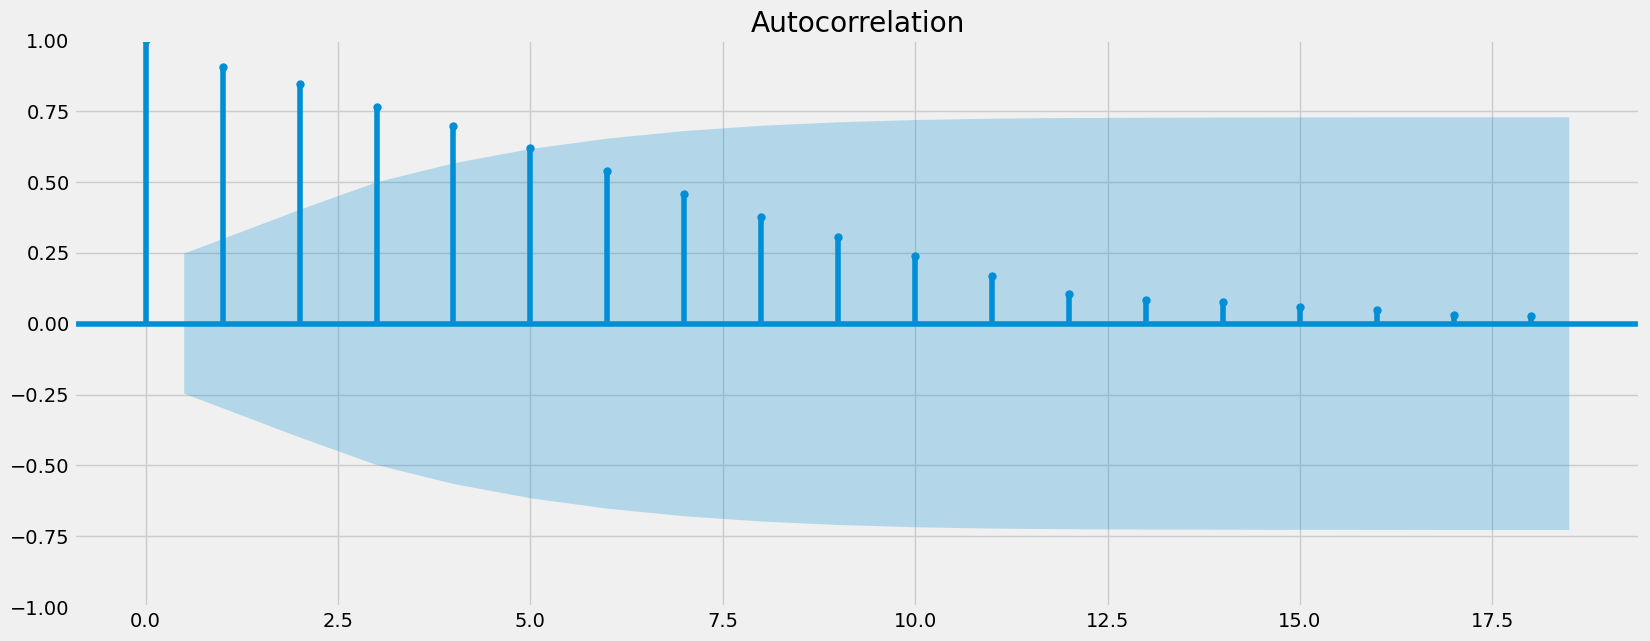

In [57]:
# Checking plot of autocorrelation

# Importing the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plt.show()

#### The test shows that vertical lines go above the blue edge of the confidence interval, indicating that the lags are significantly correlated with each other, and the data is non-stationary.

# 06. Stationarizing Data

In [58]:
# Conducting the first round of differencing by subtracting the previous data point from the current data point
# The df.shift(1) function turns the observation to t-1, making the whole data t - (t -1)

data_diff = data - data.shift(1)

In [62]:
# Removing missing values as a result of differencing

data_diff.dropna(inplace = True)

In [63]:
data_diff.head()

,n_killed
,sum
date,
2013-02-01,-9.0
2013-03-01,11.0
2013-04-01,1.0
2013-05-01,-6.0
2013-06-01,5.0


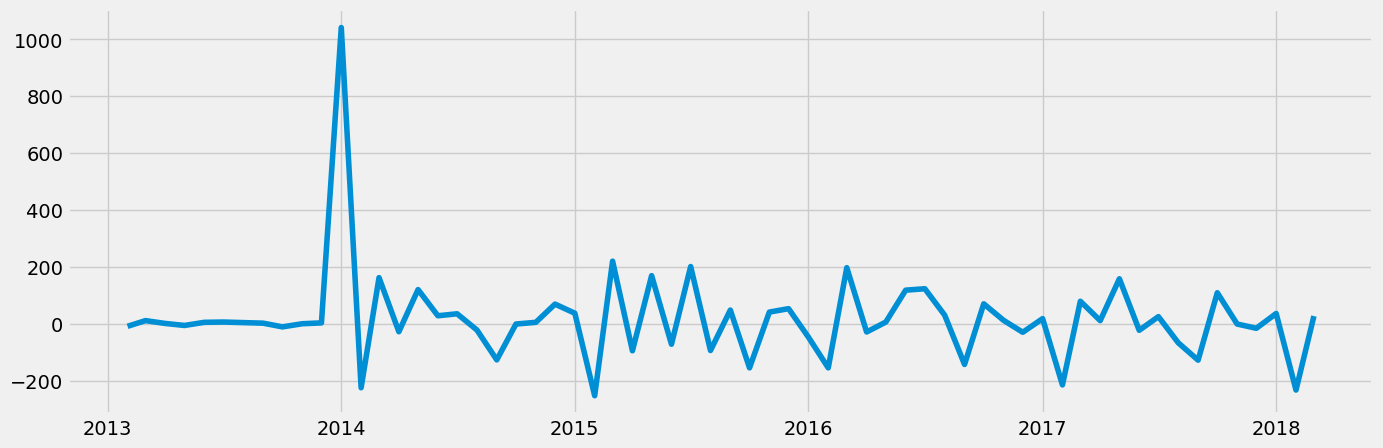

In [64]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [65]:
# Re-running the Dickey-Fuller Test to check for stationarity

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.052960e+01
p-value                        9.225262e-19
Number of Lags Used            0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


#### The same in these results show that the test statistic value (-1.05296) is larger than the critical value (5%) of -2.91023 but again to me are the numbers a bit off.

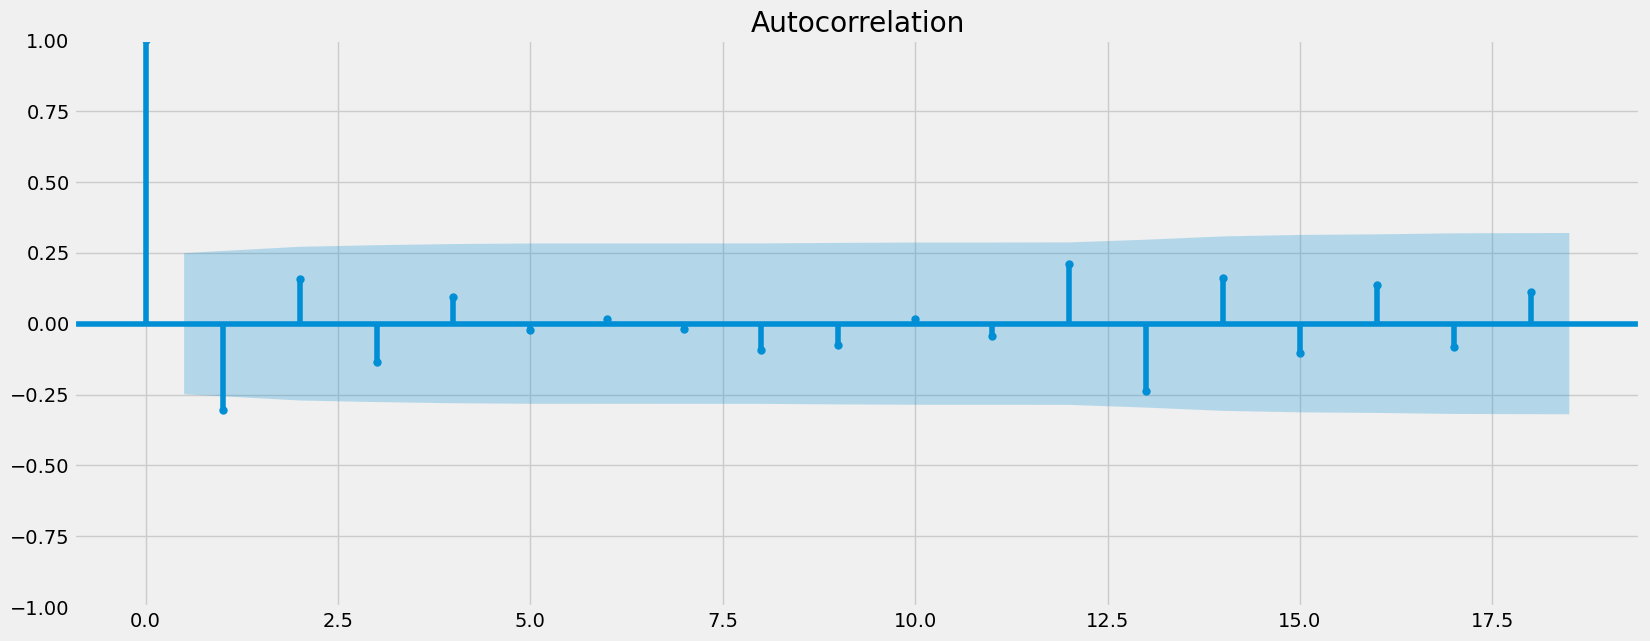

In [66]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()

#### The autocorrelation plot has changed. Now there are fewer lags above the confidence interval. I can deduce that the data is stationary.

### Exporting the data set, and saving the notebook.

In [67]:
data.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'gun_violence_script6.csv'))